In [ ]:
%matplotlib inline


# Flood Fill

Flood fill is an algorithm to identify and/or change adjacent values in an
image based on their similarity to an initial seed point [1]_. The conceptual
analogy is the 'paint bucket' tool in many graphic editors.

.. [1] https://en.wikipedia.org/wiki/Flood_fill

## Basic example

First, a basic example where we will change a checkerboard square from white
to mid-gray.


In [3]:
checkers.shape

(200, 200)

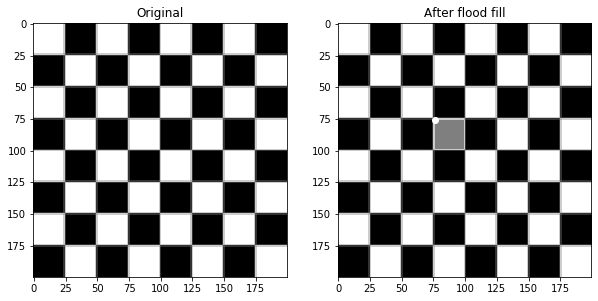

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill


checkers = data.checkerboard()

# Fill a square near the middle with value 127, starting at index (76, 76)
filled_checkers = flood_fill(checkers, (76, 76), 127)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(checkers, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filled_checkers, cmap=plt.cm.gray)
ax[1].plot(76, 76, 'wo')  # seed point
ax[1].set_title('After flood fill')

plt.show()

## Advanced example

Because standard flood filling requires the neighbors to be strictly equal,
its use is limited on real-world images with color gradients and noise.
The `tolerance` keyword argument widens the permitted range about the initial
value, allowing use on real-world images.

Here we will experiment a bit on the cameraman.  First, turning his coat from
dark to light.



In [ ]:
cameraman = data.camera()

# Change the cameraman's coat from dark to light (255).  The seed point is
# chosen as (155, 150)
light_coat = flood_fill(cameraman, (155, 150), 255, tolerance=10)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(cameraman, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(light_coat, cmap=plt.cm.gray)
ax[1].plot(150, 155, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

The cameraman's  coat is in varying shades of gray. Only the parts of the coat
matching the shade near the seed value is changed.

## Experimentation with tolerance

To get a better intuitive understanding of how the tolerance parameter
works, here is a set of images progressively increasing the parameter with
seed point in the upper left corner.



In [ ]:
output = []

for i in range(8):
    tol = 5 + 20 * i
    output.append(flood_fill(cameraman, (0, 0), 255, tolerance=tol))

# Initialize plot and place original image
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
ax[0, 0].imshow(cameraman, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

# Plot all eight different tolerances for comparison.
for i in range(8):
    m, n = np.unravel_index(i + 1, (3, 3))
    ax[m, n].imshow(output[i], cmap=plt.cm.gray)
    ax[m, n].set_title(f'Tolerance {5 + 20 * i}')
    ax[m, n].axis('off')
    ax[m, n].plot(0, 0, 'bo')  # seed point

fig.tight_layout()
plt.show()

## Flood as mask

A sister function, `flood`, is available which returns a mask identifying
the flood rather than modifying the image itself.  This is useful for
segmentation purposes and more advanced analysis pipelines.

Here we segment the nose of a cat.  However, multi-channel images are not
supported by flood[_fill].  Instead we Sobel filter the red channel to
enhance edges, then flood the nose with a tolerance.



In [ ]:
cat = data.chelsea()
cat_sobel = filters.sobel(cat[..., 0])
cat_nose = flood(cat_sobel, (240, 265), tolerance=0.03)

fig, ax = plt.subplots(nrows=3, figsize=(10, 20))

ax[0].imshow(cat)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(cat_sobel)
ax[1].set_title('Sobel filtered')
ax[1].axis('off')

ax[2].imshow(cat)
ax[2].imshow(cat_nose, cmap=plt.cm.gray, alpha=0.3)
ax[2].plot(265, 240, 'wo')  # seed point
ax[2].set_title('Nose segmented with `flood`')
ax[2].axis('off')

fig.tight_layout()
plt.show()

## Flood-fill in HSV space and mask post-processing

Since flood fill operates on single-channel images, we transform here the
image to the HSV (Hue Saturation Value) space in order to flood pixels of
similar hue.

In this example we also show that it is possible to post-process the binary
mask returned by :func:`skimage.segmentation.flood` thanks to the functions
of :mod:`skimage.morphology`.



In [ ]:
img = data.astronaut()
img_hsv = color.rgb2hsv(img)
img_hsv_copy = np.copy(img_hsv)

# flood function returns a mask of flooded pixels
mask = flood(img_hsv[..., 0], (313, 160), tolerance=0.016)
# Set pixels of mask to new value for hue channel
img_hsv[mask, 0] = 0.5
# Post-processing in order to improve the result
# Remove white pixels from flag, using saturation channel
mask_postprocessed = np.logical_and(mask,
                                    img_hsv_copy[..., 1] > 0.4)
# Remove thin structures with binary opening
mask_postprocessed = morphology.binary_opening(mask_postprocessed,
                                               np.ones((3, 3)))
# Fill small holes with binary closing
mask_postprocessed = morphology.binary_closing(
                mask_postprocessed, morphology.disk(20))
img_hsv_copy[mask_postprocessed, 0] = 0.5

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(color.hsv2rgb(img_hsv))
ax[0].axis('off')
ax[0].set_title('After flood fill')
ax[1].imshow(color.hsv2rgb(img_hsv_copy))
ax[1].axis('off')
ax[1].set_title('After flood fill and post-processing')

fig.tight_layout()
plt.show()